## Import Necessary Libraries

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


2023-05-13 22:55:55.963536: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-13 22:55:56.039377: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-13 22:55:56.040642: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 22:55:58.561717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Read Dataset

Load MNIST Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## PCA Implementation

In [3]:
def pca(X):
    mean = np.mean(X, axis=0)


    X_normalized = X - mean

    U, S, Vt = np.linalg.svd(X_normalized)

    weights = S ** 2 / (X.shape[0] - 1)
    
    vectors = Vt.T

    return mean, weights, vectors


## Using PCA before Classification

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_test.shape

(10000, 28, 28)

In [6]:
X_train = x_train.reshape(x_train.shape[0], -1)
X_test = x_test.reshape(x_test.shape[0], -1)

print('Train Shape:',X_train.shape)
print('Class Shape:',X_test.shape)

Train Shape: (60000, 784)
Class Shape: (10000, 784)


Selecting a subset of data


In [7]:
subset_size = 1000
indices = np.random.choice(X_train.shape[0], size=subset_size, replace=False)
x_train_subset = X_train[indices]
y_train_subset = y_train[indices]



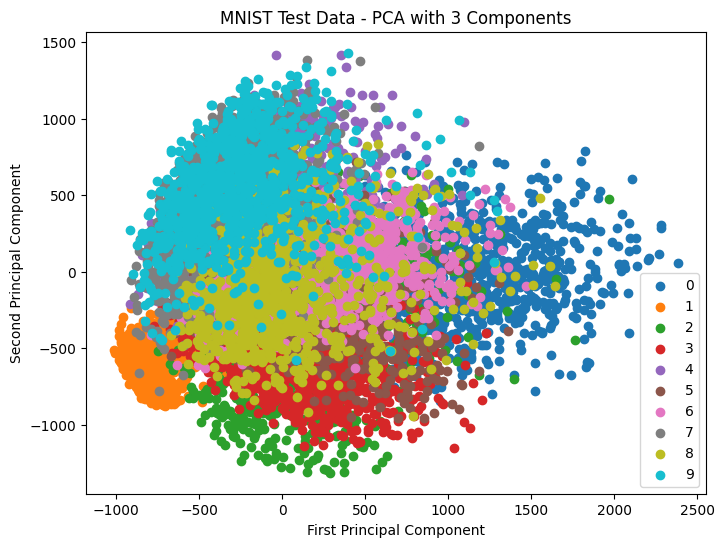

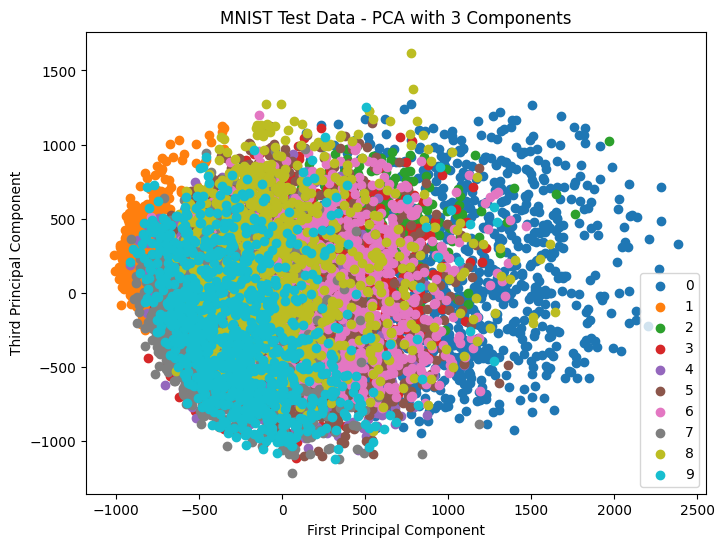

Average accuracy with 3 components: 44.00%


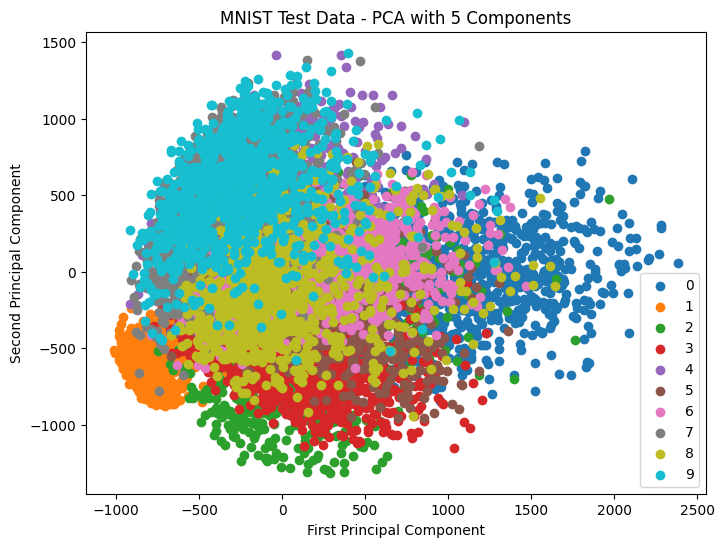

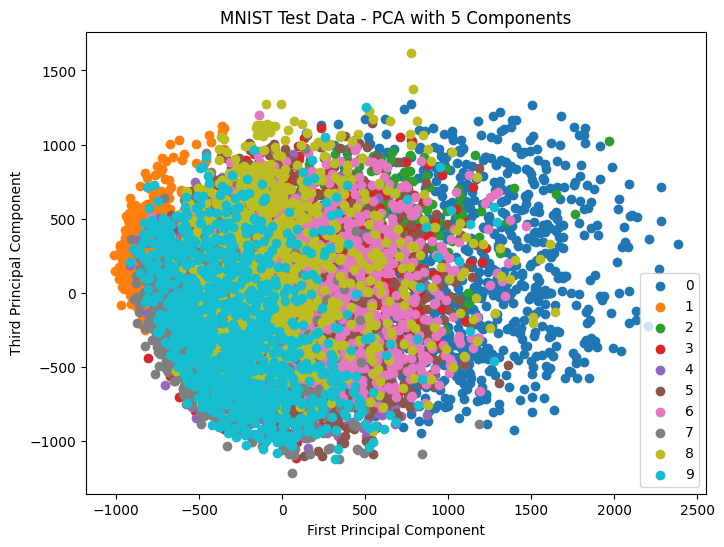

Average accuracy with 5 components: 65.20%


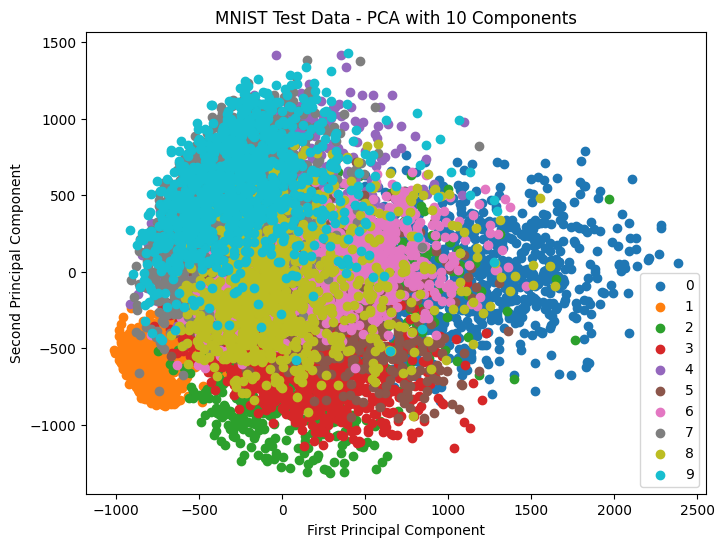

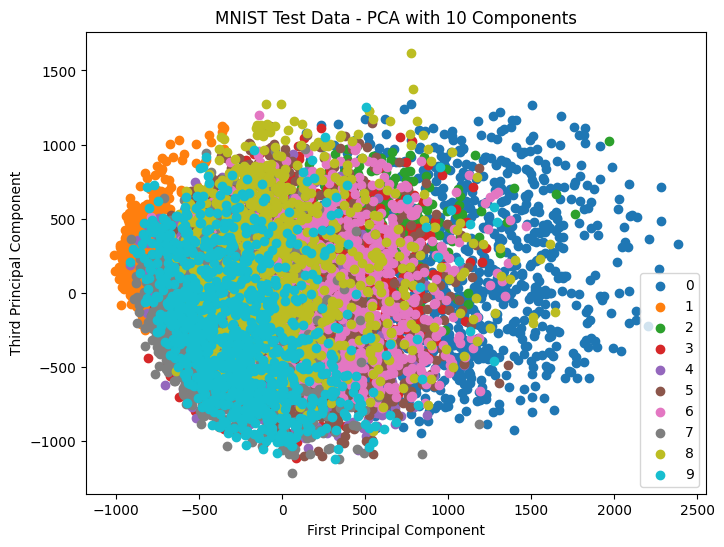

Average accuracy with 10 components: 81.20%


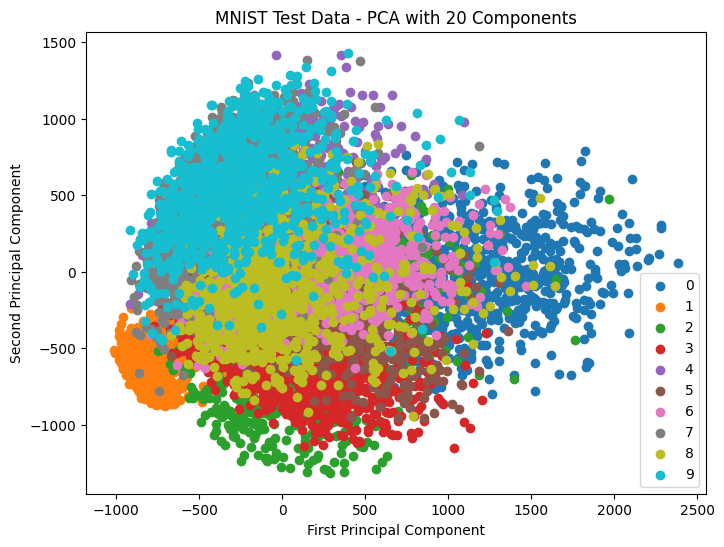

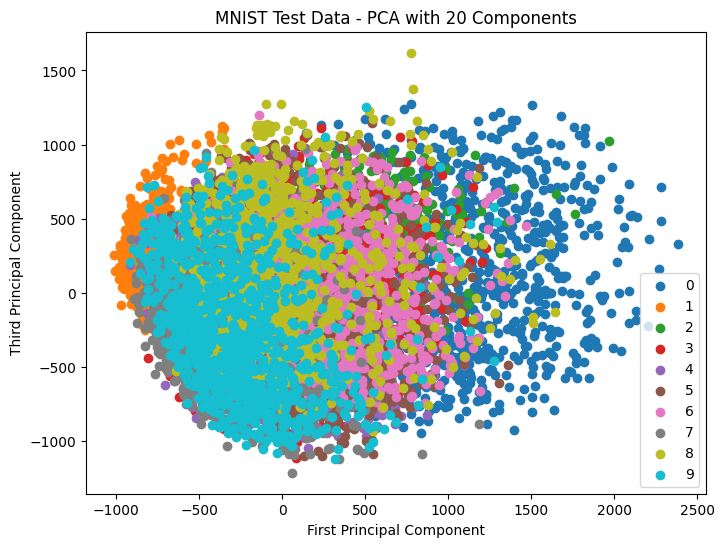

Average accuracy with 20 components: 85.40%


In [8]:
num_components = [3, 5, 10, 20]  # Choose the number of components for reduction

for n in num_components:
    mean, weights, vectors = pca(x_train_subset)

    reduced_X_train = np.dot(x_train_subset - mean, vectors[:, :n])
    reduced_X_test = np.dot(X_test - mean, vectors[:, :n])


    plt.figure(figsize=(8, 6))
    
    for i in range(10):
        indices = np.where(y_test == i)[0]
        plt.scatter(reduced_X_test[indices, 0], reduced_X_test[indices, 1], label=str(i))
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.legend()
    plt.title("MNIST Test Data - PCA with {} Components".format(n))
    plt.show()

    if n >= 3:
        plt.figure(figsize=(8, 6))
        for i in range(10):
            indices = np.where(y_test == i)[0]
            plt.scatter(reduced_X_test[indices, 0], reduced_X_test[indices, 2], label=str(i))
        plt.xlabel("First Principal Component")
        plt.ylabel("Third Principal Component")
        plt.legend()
        plt.title("MNIST Test Data - PCA with {} Components".format(n))
        plt.show()

    # Feed reduced features to Random Forest and perform classification with cross-validation
    rf = RandomForestClassifier(n_estimators=100)

    accuracies = []

    # Perform cross-validation
    kf = KFold(n_splits=5,shuffle=True) 

    for train_index, test_index in kf.split(reduced_X_train):
        x_cv_train, x_cv_test = reduced_X_train[train_index], reduced_X_train[test_index]
        y_cv_train, y_cv_test = y_train_subset[train_index], y_train_subset[test_index]

        rf.fit(x_cv_train, y_cv_train)

        y_pred = rf.predict(x_cv_test)
        accuracy = accuracy_score(y_cv_test, y_pred)
        accuracies.append(accuracy)

       

    # Calculate the average accuracy over all folds
    avg_accuracy = np.mean(accuracies)

    print("Average accuracy with {} components: {:.2f}%".format(n, avg_accuracy * 100))

    


## Non-linear Versions of PCA

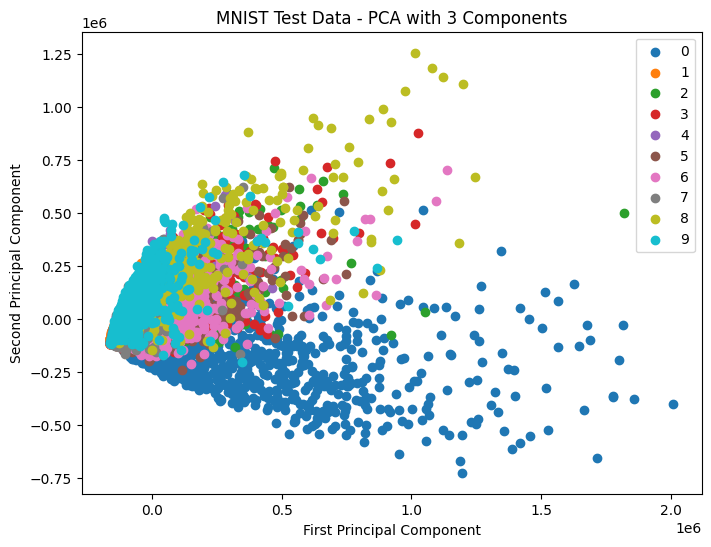

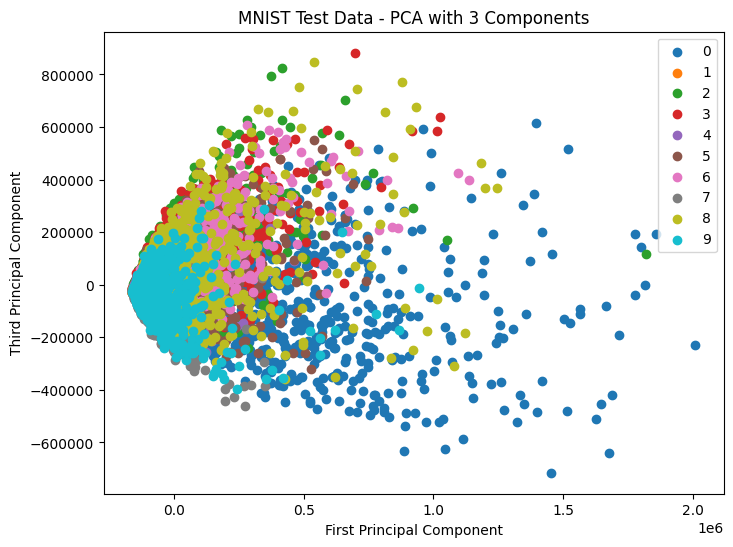

Average accuracy with 3 components: 37.10%


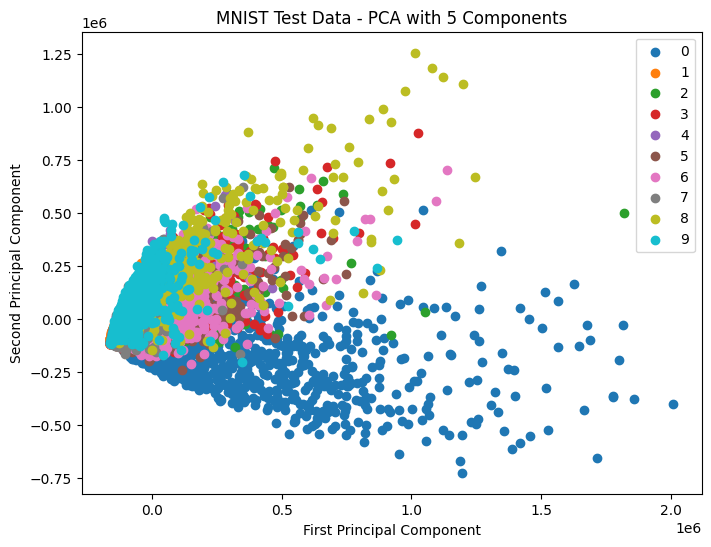

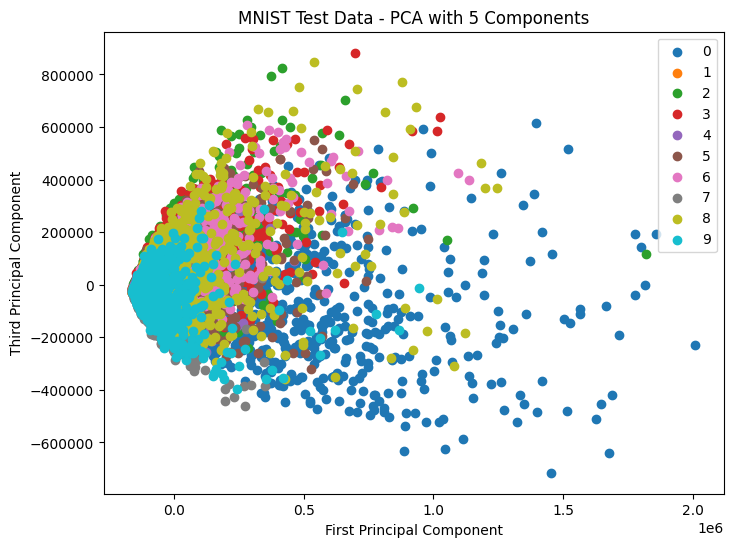

Average accuracy with 5 components: 61.10%


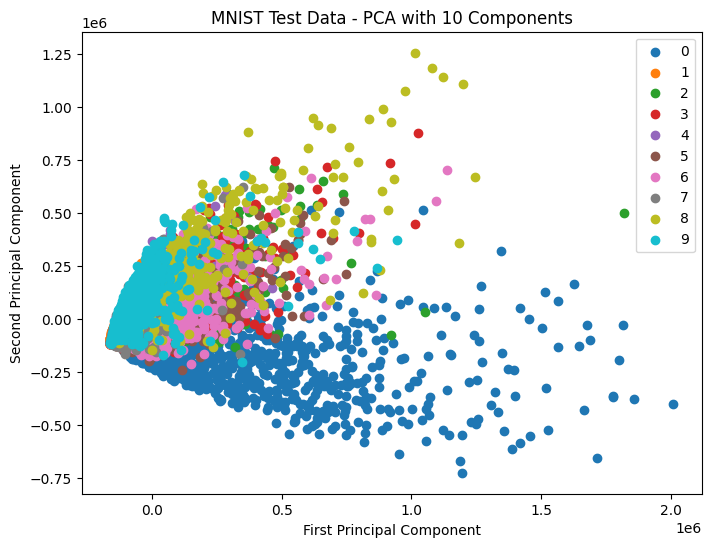

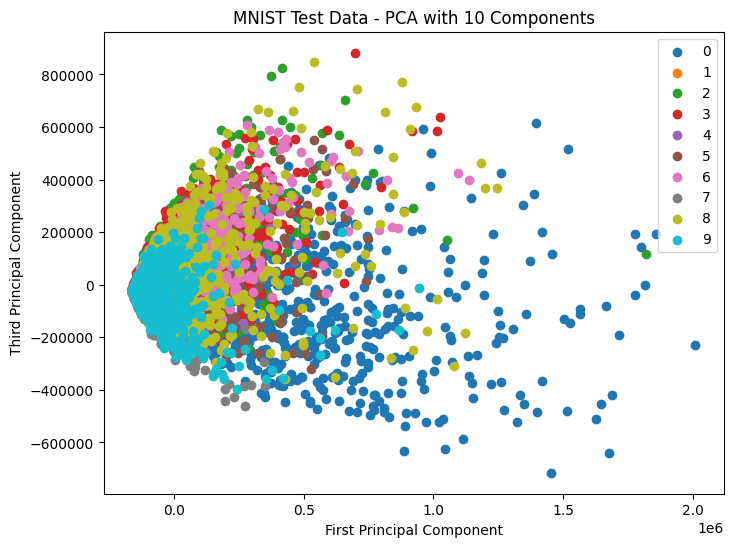

Average accuracy with 10 components: 77.20%


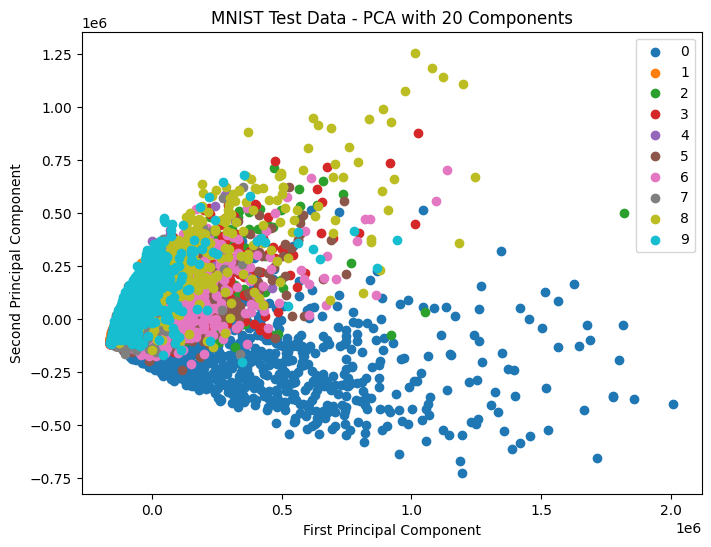

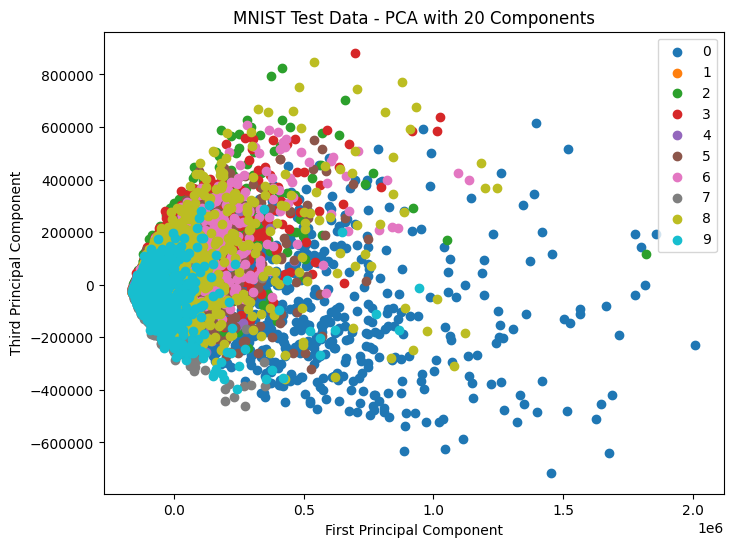

Average accuracy with 20 components: 82.50%


In [9]:
num_components = [3, 5, 10, 20]  # Choose the number of components for reduction


for n in num_components:
    kpca = KernelPCA(n_components=n, kernel='poly', degree=3)
    reduced_X_train = kpca.fit_transform(x_train_subset)
    reduced_X_test = kpca.transform(X_test)

    plt.figure(figsize=(8, 6))
    
    for i in range(10):
        indices = np.where(y_test == i)[0]
        plt.scatter(reduced_X_test[indices, 0], reduced_X_test[indices, 1], label=str(i))
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.legend()
    plt.title("MNIST Test Data - PCA with {} Components".format(n))
    plt.show()

    if n >= 3:
        plt.figure(figsize=(8, 6))
        for i in range(10):
            indices = np.where(y_test == i)[0]
            plt.scatter(reduced_X_test[indices, 0], reduced_X_test[indices, 2], label=str(i))
        plt.xlabel("First Principal Component")
        plt.ylabel("Third Principal Component")
        plt.legend()
        plt.title("MNIST Test Data - PCA with {} Components".format(n))
        plt.show()

    # Feed reduced features to Random Forest and perform classification with cross-validation
    rf = RandomForestClassifier(n_estimators=100)

    accuracies = []

    # Perform cross-validation
    kf = KFold(n_splits=5,shuffle=True)  

    for train_index, test_index in kf.split(reduced_X_train):

        x_cv_train, x_cv_test = reduced_X_train[train_index], reduced_X_train[test_index]
        y_cv_train, y_cv_test = y_train_subset[train_index], y_train_subset[test_index]

       
        rf.fit(x_cv_train, y_cv_train)

   
        y_pred = rf.predict(x_cv_test)
        accuracy = accuracy_score(y_cv_test, y_pred)
        accuracies.append(accuracy)

       

    # Calculate the average accuracy over all folds
    avg_accuracy = np.mean(accuracies)

    print("Average accuracy with {} components: {:.2f}%".format(n, avg_accuracy * 100))
